<a href="https://colab.research.google.com/github/baiyunming/I2DL-WS2020/blob/main/Lecture_10_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from tqdm.notebook import tqdm

### Define device and download image

In [2]:
# Let's run with the GPU
device = 'cuda'

In [3]:
!wget https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg -O scream.jpg
!wget https://i.imgur.com/u13WTBg.jpg -O dog.jpg

--2021-01-23 14:21:06--  https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11403121 (11M) [image/jpeg]
Saving to: ‘scream.jpg’

scream.jpg          100%[===================>]  10.87M  23.5MB/s    in 0.5s    

2021-01-23 14:21:07 (23.5 MB/s) - ‘scream.jpg’ saved [11403121/11403121]

--2021-01-23 14:21:07--  https://i.imgur.com/u13WTBg.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.52.193
Connecting to i.imgur.com (i.imgur.com)|151.101.52.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153820 (150K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 150.21K  --.-KB

### Define transform functions for image, and resize and normalize images

In [4]:
img_size = 512
resizer = transforms.Resize((img_size, img_size))
to_tensor = transforms.ToTensor()
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

style_img = Image.open('./scream.jpg')
content_img = Image.open('./dog.jpg')

style_img_unnormalize = to_tensor(resizer(style_img)).to(device)
content_img_unnormalize = to_tensor(resizer(content_img)).to(device)

style_img_normalize = normalizer(style_img_unnormalize)
content_img_normalize = normalizer(content_img_unnormalize)


Text(0.5, 1.0, 'Content Image before normalization')

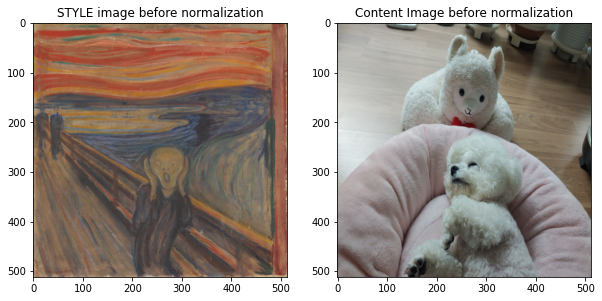

In [5]:
fig, ax = plt.subplots(1, 2, figsize= (10, 5))
ax[0].imshow(style_img_unnormalize.permute(1, 2, 0).cpu())
ax[0].set_title('STYLE image before normalization')

ax[1].imshow(content_img_unnormalize.permute(1, 2, 0).cpu())
ax[1].set_title('Content Image before normalization')

### Load Pre-trained VGG

In [6]:
# features containing the conv and pool layers (except fc layers)
vgg = models.vgg19(pretrained=True)
vgg = vgg.features.to(device)
for param in vgg.parameters():
    param.requires_grad_(False)

print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

### Function for getting feature at predefined layer index

In [7]:
def get_features(vgg, x, require_idx = [0, 5, 10, 19, 21, 28]): # conv1_1, conv2_1, conv3_1, .....
    features = []
    for l_i, layer in enumerate(vgg):
        # print(l_i, layer)
        if isinstance(layer, nn.ReLU):
            layer = nn.ReLU(inplace=False) 
        if isinstance(layer, torch.nn.MaxPool2d):
            layer = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        x = layer(x)
        if l_i in require_idx:
            features.append(x)
    return features

In [8]:
features = get_features(vgg, x=torch.zeros(1, 3, 512, 512, ).to(device))
print([f.shape for f in features])

[torch.Size([1, 64, 512, 512]), torch.Size([1, 128, 256, 256]), torch.Size([1, 256, 128, 128]), torch.Size([1, 512, 64, 64]), torch.Size([1, 512, 64, 64]), torch.Size([1, 512, 32, 32])]


### Define our training variable

In [9]:
target_img = copy.deepcopy(content_img_normalize)
target_img = target_img.requires_grad_(True)

In [10]:
optimizer = torch.optim.Adam([target_img], lr=0.1)

### Define train function

In [11]:
def train(target_img, content_img, style_img, vgg, optimizer):
    optimizer.zero_grad()
    vgg.eval()

    criterion = nn.MSELoss()
    # extract features from the vgg
    target_features = get_features(vgg, target_img.unsqueeze(0))
    content_features = get_features(vgg, content_img.unsqueeze(0))
    style_features = get_features(vgg, style_img.unsqueeze(0))
    # in side list of features, there would be (B X C X W X H) tensor.

    ## calculate content loss from the second last element in features
    content_loss = criterion(target_features[-2], content_features[-2].detach())

    ## calculate style loss from indexes of 0, 5, 10, 19, 28
    ## give 0.2 weight.

    style_loss = 0.0

    ## index 21 was only for the content loss.
    del target_features[-2] 
    del style_features[-2] 
    del content_features[-2]

    for t_f, s_f in zip(target_features, style_features):
        B, C, H, W = t_f.shape
        t_f = t_f.view(B*C, H*W)
        s_f = s_f.view(B*C, H*W)

        # print(t_f.shape, s_f.shape)
        
        t_gram = torch.mm(t_f, t_f.permute(1, 0))
        s_gram = torch.mm(s_f, s_f.permute(1, 0))
    
        style_loss += criterion(t_gram, s_gram.detach()) / (4*(C**2)*(H*W)**2)

    total_loss = content_loss + 1e8*style_loss

    total_loss.backward()
    optimizer.step()

    return total_loss.item()


In [12]:
train(target_img, content_img_normalize, style_img_normalize, vgg, optimizer)

2311.642578125

### Start Training

In [14]:
def plot_target(target_img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    target_img_unnormalize = copy.deepcopy(target_img)
    for i in range(3):
        target_img_unnormalize[i, :, :] = target_img[i, :, :] * std[i] + mean[i]
    plt.imshow(target_img_unnormalize.detach().cpu().permute(1, 2, 0))
    plt.pause(0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.953922748565674


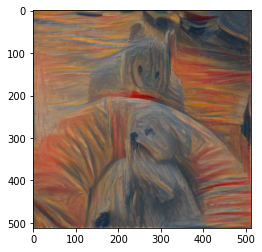

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


16.67050552368164


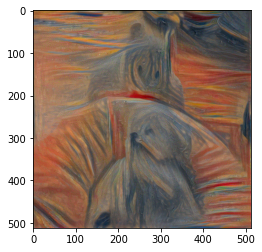

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4.3964691162109375


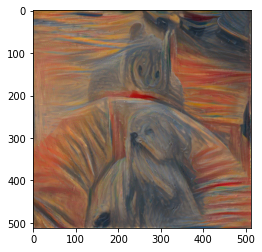

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.719698429107666


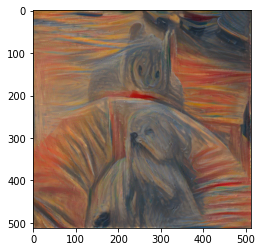

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4.369752407073975


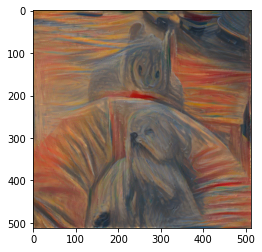

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4.519812107086182


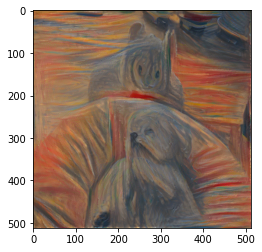

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7.475140571594238


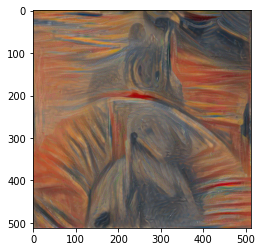

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4.021565914154053


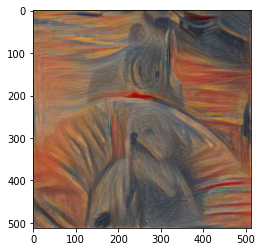

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5.020866394042969


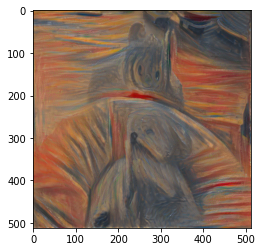

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.452662944793701


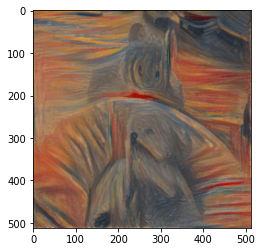

In [17]:
max_iter = 1000
for i in tqdm(range(max_iter)):
    curr_loss = train(target_img, content_img_normalize, style_img_normalize, vgg, optimizer)
    if i % 100 == 0:
        print(curr_loss)
        plot_target(target_img)